In [295]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import r2_score, precision_recall_fscore_support, balanced_accuracy_score

import pandas as pd
import numpy as np
import seaborn as sns

from my_util import *
from lime.lime.lime_tabular import LimeTabularExplainer

# from pyexplainer.pyexplainer_pyexplainer import PyExplainer
import matplotlib.pyplot as plt

import os, pickle, time, re, sys
from datetime import datetime
from collections import Counter


sys.path.append(os.path.abspath('../pyexplainer'))
from pyexplainer_pyexplainer import *


In [167]:
data_path = './dataset/'
result_dir = './eval_result/'
dump_dataframe_dir = './dump_df/'
pyExp_dir = './pyExplainer_obj/'
other_object_dir = './other_object/'
# proj_name = 'qt' # ['openstack','qt']

In [201]:
def get_top_k_global_features(global_model, indep, top_k_global_feature_num = 5):
    global_feature_df = pd.DataFrame()
    global_feature_df['feature'] = indep
    global_feature_df['importance'] = global_model.feature_importances_

    global_feature_df = global_feature_df.sort_values(by='importance',ascending=False)

    top_k_global_features = list(global_feature_df['feature'])[:top_k_global_feature_num]

    return top_k_global_features
    
def get_rule_str_of_rulefit(local_rulefit_model):
    rule_df = local_rulefit_model.get_rules()
    top_k = 5
    top_k_positive_rules = rule_df[(rule_df.coef > 0) & (rule_df.type=='rule')].sort_values("importance", ascending=False).head(top_k)

    the_best_defective_rule_str = list(top_k_positive_rules['rule'])[0]
    
    return the_best_defective_rule_str

def aggregate_list(l):
    return np.mean(l), np.median(l)


In [291]:
# '''
#     synthetic_inst1: generated instance used with global model
#     synthetic_inst2: generated instance used with local model
#     global_model, local_model: any sklearn ML model or ML model that is extended from ML model
# '''
# def cal_bal_acc(synthetic_inst1, synthetic_inst2, global_model, local_model):
#     global_pred = global_model.predict(synthetic_inst1)
#     local_pred = local_model.predict(synthetic_inst2)
    
#     # in case prediction of local model is not binary 
#     if set(local_pred) != set([True, False]):
#         local_pred = np.round(local_pred)
#         local_pred = [True if val else False for val in local_pred]
        
#     bal_acc = balanced_accuracy_score(global_pred, local_pred)
#     return bal_acc
    
# def cal_r2_score(synthetic_inst1, synthetic_inst2, global_model, local_model):
#     global_pred = global_model.predict(synthetic_inst1)
#     local_pred = local_model.predict(synthetic_inst2)
    
#     global_pred = [1 if val else 0 for val in global_pred]
#     # in case prediction of local model is not binary 
#     if set(local_pred) != set([1, 0]):
#         local_pred = np.round(local_pred)
#         local_pred = [1 if val else 0 for val in local_pred]
        
#     r2_scr = r2_score(global_pred, local_pred)
#     return r2_scr

def is_in_top_k_global_features(top_k_global_features, the_best_defective_rule_str):
    # remove numeric value
    new_the_best_defective_rule_str = re.sub('\d+','', the_best_defective_rule_str)

    # remove special characters
    new_the_best_defective_rule_str = re.sub('\W+',' ',new_the_best_defective_rule_str)
    splitted_rule = new_the_best_defective_rule_str.split()

#     ret = False
    local_feature_count = 0
    
    found_features = set(splitted_rule).intersection(top_k_global_features)
#     for tok in splitted_rule:
#         if tok.strip() in top_k_global_features:
#             found_features.append(tok)
#             ret = True
#             break
#             local_feature_count = local_feature_count+1
#     local_feature_ratio = local_feature_count/len(splitted_rule)
#     return ret
#     return local_feature_ratio
    return list(found_features)

def eval_rule(rule, X_explain):
    var_in_rule = re.findall('[a-zA-Z]+',rule)
    rule = rule.replace('&','and') # just for rulefit
    rule = re.sub(r'\b=\b','==',rule)
#             rule = rule.replace('=','==')

    var_dict = {}

    for var in var_in_rule:
        var_dict[var] = float(X_explain[var])

    eval_result = eval(rule,var_dict)
    return eval_result
        
def eval_local_model(proj_name):
    global_model = pickle.load(open(proj_name+'_global_model.pkl','rb'))

    correctly_predict_df = pd.read_csv(dump_dataframe_dir+proj_name+'_correctly_predict_as_defective.csv')
    correctly_predict_df = correctly_predict_df.set_index('commit_id')

    dep = 'defect'
    indep = correctly_predict_df.columns[:-3] # exclude the last 3 columns

    feature_df = correctly_predict_df.loc[:, indep]

    top_k_global_features = get_top_k_global_features(global_model, indep)
    print('top-k global features:',top_k_global_features)
    total_top_k_global_features = len(top_k_global_features)

    py_exp_is_in_top_k_global_features_count = 0
    lime_exp_is_in_top_k_global_features_count = 0

    # project, commit id , method, euc_dist_mean, euc_dist_med, defective_generated_instance_ratio
    # bal_acc, r2_score

    # one dataframe for every RQ and every METHOD !!!!
    all_eval_result = pd.DataFrame()

    py_exp_found_global_features = []
    lime_found_global_features = []
    
    py_exp_rule_count = 0
    lime_rule_count = 0
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]
    #     y_explain = test_label.iloc[[i]]

        row_index = str(X_explain.index[0])

        py_exp = pickle.load(open(pyExp_dir+proj_name+'_rulefit_crossoverinterpolation_'+row_index+'.pkl','rb'))
        lime_exp = pickle.load(open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','rb'))

        # this data can be used for both local and global model
        py_exp_synthetic_data = py_exp['synthetic_data'].values
        # this data can be used with global model only
        lime_exp_synthetic_data = lime_exp['synthetic_instance_for_global_model'] 
        # this data can be used with lobal model only
        lime_exp_synthetic_data_local = lime_exp['synthetic_instance_for_lobal_model']

        py_exp_local_model = py_exp['local_model']
        lime_exp_local_model = lime_exp['local_model']

        # make a prediction for later use
        py_exp_global_pred = global_model.predict(py_exp_synthetic_data)
        py_exp_local_pred = py_exp_local_model.predict(py_exp_synthetic_data)
        py_exp_local_pred = [1 if val else 0 for val in py_exp_local_pred]

        lime_exp_global_pred = global_model.predict(lime_exp_synthetic_data)
        lime_exp_local_pred = lime_exp_local_model.predict(lime_exp_synthetic_data_local)
        lime_exp_local_pred = np.round(lime_exp_local_pred)


#         # for RQ1 (single numeric value)
#         py_exp_dist = euclidean_distances(X_explain.values, py_exp_synthetic_data)
#         lime_dist = euclidean_distances(X_explain.values, lime_exp_synthetic_data)

#         py_exp_dist_mean, py_exp_dist_med = aggregate_list(py_exp_dist)
#         lime_exp_dist_mean, lime_exp_dist_med = aggregate_list(lime_dist)

#         # for RQ1 (single numeric value)
#         py_exp_def_pred_ratio = np.sum(py_exp_local_pred)/len(py_exp_local_pred)
#         lime_exp_def_pred_ratio = np.sum(lime_exp_local_pred)/len(lime_exp_local_pred)

#         # for RQ2 (single numeric value)
#         py_exp_bal_acc = balanced_accuracy_score(py_exp_global_pred, py_exp_local_pred)
#         lime_exp_bal_acc = balanced_accuracy_score(lime_exp_global_pred, lime_exp_local_pred)

#         # for RQ3 (single numeric value)
#         py_exp_r2_scr = r2_score(py_exp_global_pred, py_exp_local_pred)
#         lime_exp_r2_scr = r2_score(lime_exp_global_pred, lime_exp_local_pred)

        # for RQ4 (single numeric value)
            
        py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit(py_exp_local_model)
        lime_exp_the_best_defective_rule_str = lime_exp['rule'].as_list()[0][0]

#         py_exp_eval = eval_rule(py_exp_the_best_defective_rule_str, X_explain)
#         lime_eval = eval_rule(lime_exp_the_best_defective_rule_str, X_explain)
        
#         if py_exp_eval:
#             py_exp_rule_count = py_exp_rule_count + 1
#         if lime_eval:
#             lime_rule_count = lime_rule_count + 1
            
#         if not py_exp_eval:
#             print(py_exp_the_best_defective_rule_str)
#             print(X_explain)
#             print('-'*100)
            
#         print(py_exp_eval, lime_eval)
        
        py_exp_is_in_top_k_global_features = is_in_top_k_global_features(top_k_global_features, 
                                                                         py_exp_the_best_defective_rule_str)
        lime_exp_is_in_top_k_global_features = is_in_top_k_global_features(top_k_global_features, 
                                                                           lime_exp_the_best_defective_rule_str)

#         print(py_exp_is_in_top_k_global_features)
#         print(lime_exp_is_in_top_k_global_features)
        
        if len(py_exp_is_in_top_k_global_features) > 0:
            py_exp_is_in_top_k_global_features_count = py_exp_is_in_top_k_global_features_count+1
        if len(lime_exp_is_in_top_k_global_features) > 0:
            lime_exp_is_in_top_k_global_features_count = lime_exp_is_in_top_k_global_features_count+1
        
        py_exp_found_global_features.extend(py_exp_is_in_top_k_global_features)
        lime_found_global_features.extend(lime_exp_is_in_top_k_global_features)
        
        py_exp_serie = pd.Series(data=[proj_name, row_index, 'crossover_interpolation',py_exp_dist_mean, 
                                       py_exp_dist_med, py_exp_def_pred_ratio, py_exp_bal_acc, 
                                       py_exp_r2_scr, py_exp_is_in_top_k_global_features])
        lime_exp_serie = pd.Series(data=[proj_name, row_index, 'LIME', lime_exp_dist_mean, 
                                         lime_exp_dist_med, lime_exp_def_pred_ratio, lime_exp_bal_acc, 
                                         lime_exp_r2_scr, lime_exp_is_in_top_k_global_features])

        all_eval_result = all_eval_result.append(py_exp_serie,ignore_index=True)
        all_eval_result = all_eval_result.append(lime_exp_serie, ignore_index=True)

#         print('finished',row_index)

#         break
        
    py_exp_found_feature_count = Counter(py_exp_found_global_features)
    lime_found_feature_count = Counter(lime_found_global_features)

    print(py_exp_found_feature_count)
    print(lime_found_feature_count)
    
    plt.figure()
    plt.hist(py_exp_found_global_features)
    plt.gca().set(title='Frequency Histogram of py_exp', ylabel='Frequency')
    plt.show()
    
    plt.figure()
    plt.hist(lime_found_global_features)
    plt.gca().set(title='Frequency Histogram of LIME', ylabel='Frequency')
    plt.show()
    
#     print(set(py_exp_found_global_features))
#     print(set(lime_found_global_features))
#     all_eval_result.columns=['project', 'commit id', 'method', 'euc_dist_mean', 'euc_dist_med', 
#                              'defective_generated_instance_ratio', 'bal_acc', 'r2_score', 'local_feature_ratio']

#     all_eval_result.to_csv('./eval_result/'+proj_name+'_RQ1_RQ4_eval.csv',index=False)
    
#     print('finished evaluation')
#     print('ratio of test instances of py_exp that their features in the rules appear in global feature', 
#           py_exp_is_in_top_k_global_features_count/len(feature_df))
#     print('ratio of test instances of LIME that their features in the rules appear in global feature',
#           lime_exp_is_in_top_k_global_features_count/len(feature_df))

#     print(py_exp_rule_count, lime_rule_count)

top-k global features: ['ent', 'nrev', 'la', 'app', 'rtime']
Counter({'nrev': 69, 'la': 61, 'ent': 56, 'app': 48, 'rtime': 34})
Counter({'la': 171, 'ent': 22, 'nrev': 1})


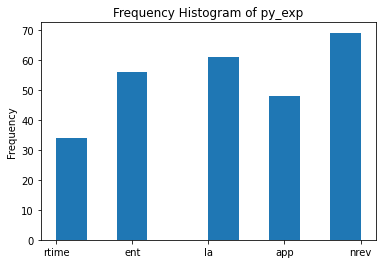

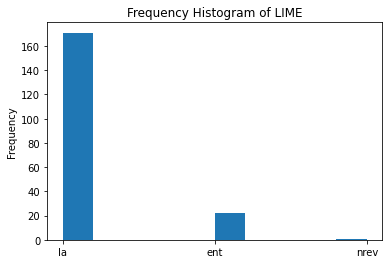

In [292]:
eval_local_model('openstack')

top-k global features: ['nrev', 'ent', 'la', 'ndev', 'hcmt']
Counter({'la': 22, 'ent': 21, 'ndev': 16, 'nrev': 16, 'hcmt': 13})
Counter({'la': 36, 'hcmt': 8, 'ent': 3})


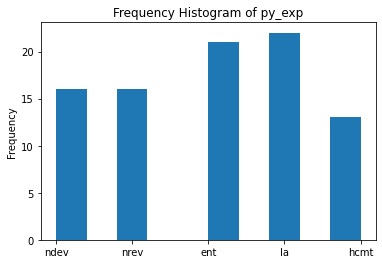

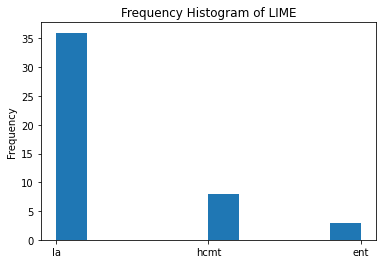

In [293]:
# all_eval_result.columns=['project', 'commit id', 'method', 'euc_dist_mean', 'euc_dist_med', 
#                          'defective_generated_instance_ratio', 'bal_acc', 'r2_score', 'local_feature_ratio']
# print(all_eval_result.head())
# all_eval_result.to_csv('./eval_result/'+proj_name+'_RQ1_RQ4_eval.csv',index=False)
eval_local_model('qt')

In [95]:
print(py_exp_is_in_top_k_global_features_count/len(feature_df), 
      lime_exp_is_in_top_k_global_features_count/len(feature_df))

0.7341772151898734 0.5949367088607594


In [172]:
# proj_name = 'openstack'
openstack_result_df = pd.read_csv('./eval_result/openstack_RQ1_RQ4_eval.csv')
qt_result_df = pd.read_csv('./eval_result/qt_RQ1_RQ4_eval.csv')

result_df = pd.concat([openstack_result_df, qt_result_df])
print(len(result_df))

554


In [142]:
print(openstack_result_df.head())

     project                                 commit id  \
0  openstack  1e6973aee7137653c62dcef970b1e2527b50517d   
1  openstack  1e6973aee7137653c62dcef970b1e2527b50517d   
2  openstack  5d0ccceb20780fdd3adf519d3f8e6b80b1844407   
3  openstack  5d0ccceb20780fdd3adf519d3f8e6b80b1844407   
4  openstack  de31210c05f464c4a79255de68b1a515d9b84ed3   

                    method  euc_dist_mean  euc_dist_med  \
0  crossover_interpolation     402.001480    331.704115   
1                     LIME     891.144954    547.648247   
2  crossover_interpolation     563.188939    488.590016   
3                     LIME    1372.434025   1384.777800   
4  crossover_interpolation     296.285365    233.747669   

   defective_generated_instance_ratio   bal_acc  r2_score  local_feature_ratio  
0                            0.431452  0.914181  0.664601                  0.4  
1                            0.050800  0.579753 -0.126152                  0.2  
2                            0.689435  1.000000  1.00

<AxesSubplot:xlabel='project', ylabel='euc_dist_med'>

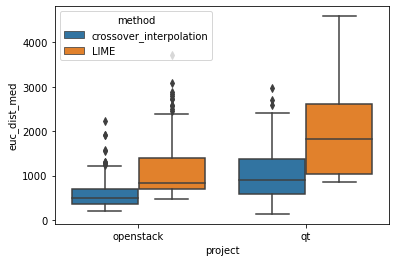

In [173]:
# RQ1: euc_dist_med
sns.boxplot(data=result_df, x='project', y='euc_dist_med', hue='method')

<AxesSubplot:xlabel='project', ylabel='defective_generated_instance_ratio'>

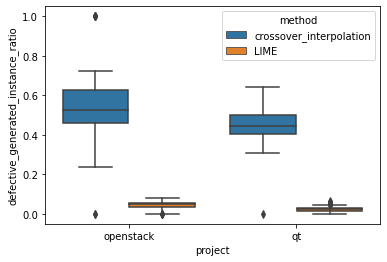

In [174]:
# RQ1: defective_generated_instance_ratio
sns.boxplot(data=result_df, x='project', y='defective_generated_instance_ratio', hue='method')

<AxesSubplot:xlabel='project', ylabel='bal_acc'>

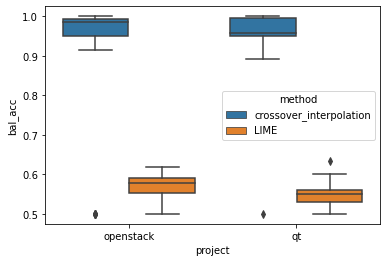

In [175]:
# RQ2: bal_acc
sns.boxplot(data=result_df, x='project', y='bal_acc', hue='method')

<AxesSubplot:xlabel='project', ylabel='r2_score'>

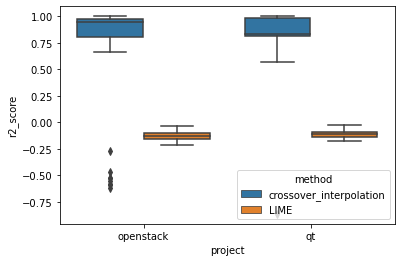

In [176]:
# RQ3: r2_score
sns.boxplot(data=result_df, x='project', y='r2_score', hue='method')

     project                   method     ratio
0  openstack  crossover_interpolation  0.848400
1  openstack                     LIME  0.979797
2         qt  crossover_interpolation  0.734120
3         qt                     LIME  0.594936


<AxesSubplot:xlabel='project', ylabel='ratio'>

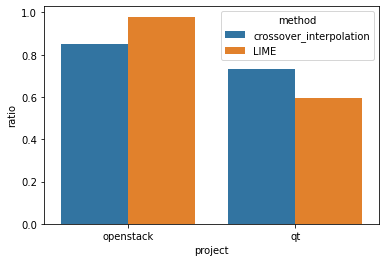

In [112]:
# RQ4: ratio of rules of which features appear in top-k global feature
rq4_df = pd.DataFrame()
rq4_df = rq4_df.append(pd.Series(['openstack','crossover_interpolation',0.8484]), ignore_index=True)
rq4_df = rq4_df.append(pd.Series(['openstack','LIME',0.979797]), ignore_index=True)
rq4_df = rq4_df.append(pd.Series(['qt','crossover_interpolation',0.73412]), ignore_index=True)
rq4_df = rq4_df.append(pd.Series(['qt','LIME',0.594936]), ignore_index=True)

rq4_df.columns = ['project','method','ratio']
print(rq4_df)

sns.barplot(data=rq4_df, x="project", y="ratio", hue="method")

<AxesSubplot:xlabel='project', ylabel='local_feature_ratio'>

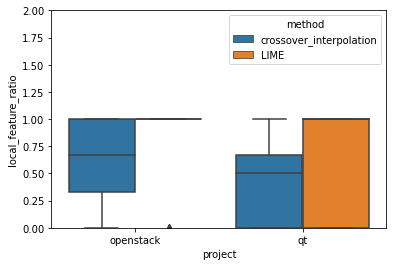

In [179]:
# RQ4 (new)
plt.ylim(0,2)
sns.boxplot(data=result_df, x='project', y='local_feature_ratio', hue='method')

In [189]:
print(np.median(result_df[(result_df['project']=='qt') & (result_df['method']=='LIME')]['local_feature_ratio']))

1.0
